In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import root, minimize
import yfinance as yf
import matplotlib.pyplot as plt

# !pip install py_vollib      # uncomment this line if py_vollib was not installed
from py_vollib.black_scholes import black_scholes as bs

### 17.2.6 Black-Scholes Model in an FX Setting

In this coding example, we show how this modified version of the Black-Scholes model can be used to price vanilla call options on an exchange rate:

In [ ]:
def fxBsCall(S0, K, sigma, r_d, r_f, T):
    F = S0 * np.exp ((r_d - r_f) * T)
    d1 = (1/(sigma*np.sqrt(T))) * (np.log(F/K) + 0.5*(sigma**2)*T)
    d2 = d1 - sigma*np.sqrt(T)
    pxCall = np.exp(-r_d*T) * (F*norm.cdf(d1) - K*norm.cdf(d2))
    return pxCall

In [ ]:
S0, K, sigma, r_d, r_f, T = 1.2, 1.25, 0.1, 0.02, 0.05, 1
print('Price of the FX rate call option of the domestic currency: {}'.format(fxBsCall(S0, K, sigma, r_d, r_f, T)))

Price of the FX rate call option of the domestic currency: 0.016651425048556594


The reader should note that the risk-free rate in this Black-Scholes pricing formula should correspond to the risk-free rate of the domestic currency.

### 17.3.2 FX Volatility Surfaces in Practice: Comparison across Currency Pairs

The following example visualizes a calibrated volatility table. Readers are welcome to reuse it with their own data.

*Note: If you are not running this notebook from the default GitHub directory, please download `volSurfaces3MCombined.xlsx` from the `data/` folder, upload it to your current working directory, and remove `data/` from the file path.*

In [ ]:
df_vol_surface = pd.read_excel('volSurfaces3MCombined.xlsx', index_col=0)
df_vol_surface

,CADMXN,CHFRUB,GBPAUD,USDBRL,USDEUR
Delta Call,,,,,
0.05,0.13247,0.18791,0.08504,0.22848,0.06069
0.10,0.12471,0.17629,0.08001,0.21796,0.05858
0.25,0.10877,0.14627,0.07170,0.19349,0.05533
0.50,0.09664,0.12160,0.06640,0.17182,0.05348
0.75,0.09179,0.11020,0.06640,0.15936,0.05418
0.90,0.09158,0.10607,0.06999,0.15344,0.05633
0.95,0.09232,0.10479,0.07276,0.15102,0.05789


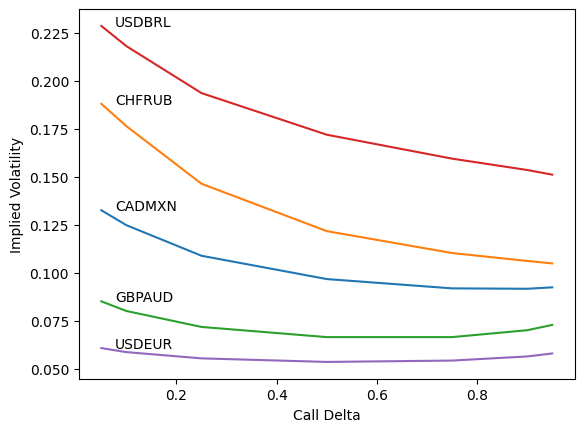

In [ ]:
df_vol_surface.plot(legend=False)

for i in range(len(df_vol_surface.columns)):
    currency_pair = df_vol_surface.columns[i]
    plt.annotate(currency_pair,
                 (df_vol_surface.index[0], df_vol_surface.iloc[0,i]),
                 textcoords="offset points",
                 xytext=(10,0),
                 ha='left', fontsize=10)

plt.xlabel('Call Delta')
plt.ylabel('Implied Volatility')
plt.show()

### 17.4.1 Digital Options; 17.4.2 One Touch Options

In the following coding example, we detail how digital and one-touch prices can be computed given a set of simulated paths:

In [ ]:
def priceDigiCall(paths, K, r, T):
    """paths: 2D np array, each subarray represents a period in time"""
    terminalVals = paths[-1]
    payoffs = np.where(terminalVals > K, 1, 0)
    return np.exp(-r*T)*np.mean(payoffs)

def priceOneTouchCall(paths, K, r, T):
    """paths: 2D np array, each subarray represents a period in time"""
    maxVals = np.max(paths, axis = 0)
    payoffs = np.where(maxVals > K, 1, 0)
    return np.exp(-r*T)*np.mean(payoffs)

For more details on how to build the code to generate the underlying simulated paths, the reader is encouraged to refer to coding examples in chapter 12.

### 17.4.3 One-Touches vs. Digis in Practice: Ratio of Prices in EURJPY

In this coding example, we first show how to calibrate a SABR model to a set of standard market quotes: the at-the-money (ATM) implied volatility, the 25-delta risk reversal (RR), and the 25-delta strangle. Market 25-delta call and put strikes are first constructed from the quoted ATM volatility, RR, and strangle using consistent market conventions. These strikes are held fixed throughout the calibration. The SABR parameters are then estimated by minimizing the squared differences between market quotes and model-implied quantities, including the ATM implied volatility, the 25-delta RR, and the 25-delta strangle price.

Note that we calculate BS call/put prices using the built-in `black_scholes()` function from [`py_vollib`](https://vollib.org/documentation/1.0.3/autoapi/py_vollib/index.html) (imported at the top of this notebook) to skip manual implementation.

In [ ]:
# reuse functions from previous chapters
def sabr_normal_vol(S_0, K, T, sigma_0, alpha, beta, rho):          # 10.2.3
    c = lambda x: x**beta
    c_prime = lambda x: beta*(x**(beta-1))
    c_prime_prime = lambda x: beta*(beta-1)*(x**(beta-2))
    S_mid = (S_0 + K)/2
    gamma_1 = c_prime(S_mid)/c(S_mid)
    gamma_2 = c_prime_prime(S_mid)/c(S_mid)
    zeta = alpha*(S_0**(1-beta) - K**(1-beta))/(sigma_0 * (1-beta))
    epsilon = T*(alpha**2)
    delta = np.log( (np.sqrt(1 - 2*rho*zeta + zeta**2) + zeta - rho)/(1-rho) )

    factor = alpha*(S_0 - K)/(delta)
    term_1 = ((2*gamma_2 - gamma_1**2)/24)* (sigma_0*c(S_mid)  / alpha)**2
    term_2 = rho*gamma_1*sigma_0*c(S_mid)/(4*alpha)
    term_3 = (2-3*(rho**2))/24
    return factor*(1 + epsilon*(term_1 + term_2 + term_3))

def bachelier_call(S_0, K, T, sigma, r):                            # 10.1.4
    d_plus = (S_0*np.exp(r*T) - K)/(sigma*np.sqrt(T))
    return np.exp(-r*T)*sigma*np.sqrt(T)*(d_plus*norm.cdf(d_plus) + norm.pdf(d_plus))

def get_implied_vol_bs(S_0, K, T, r, observed_px, initial_guess):   # 11.4.4
    root_fn = lambda x: bs_call(S_0,K,T,x,r) - observed_px
    return root(root_fn,initial_guess)['x'][0]

def bs_call(S_0, K, T, sigma, r):                                   # 10.1.1
    d_1 = (np.log(S_0/K) + T*(r + (sigma**2)/2))/(sigma*np.sqrt(T))
    d_2 = d_1 - sigma*np.sqrt(T)
    return S_0*norm.cdf(d_1) - K*np.exp(-r*T)*norm.cdf(d_2)

In [ ]:
# define the objective function
def bs_sabr_vol(F_0, K, T, sigma_0, beta, alpha, rho):

    if T <= 0 or F_0 <= 0 or K <= 0:
        return np.nan

    normVol = sabr_normal_vol(F_0, K, T, beta, sigma_0, alpha, rho)
    if (not np.isfinite(normVol)) or (normVol <= 0):
        return np.nan

    normPx = bachelier_call(F_0, K, T, normVol, 0.0)
    if (not np.isfinite(normPx)) or (normPx < 0):
        return np.nan

    impVol = get_implied_vol_bs(F_0, K, T, 0.0, normPx, 0.2)
    if (not np.isfinite(impVol)) or (impVol <= 0):
        return np.nan

    return impVol


def strikeGivenDelta(F_0, T, delta, sigma):
    K = F_0 * np.exp(-sigma*np.sqrt(T)*norm.ppf(delta) + 0.5*(sigma**2)*T);
    return K


BIG = 1e10

def objectiveFunctionFX(params, beta, F_0, T, K_atm, K_c_st, K_p_st, r_d, sigma_atm, rr_vol, st_px):

    if params[0] <= 0 or params[1] <= 0 or not (-0.999 < params[2] < 0.999):
        return BIG
    if T <= 0 or F_0 <= 0 or K_atm <= 0 or K_c_st <= 0 or K_p_st <= 0:
        return BIG

    # volatility
    sigma_atm_hat = bs_sabr_vol(F_0, K_atm, T, params[0], beta, params[1], params[2])
    sigma_st_c_hat = bs_sabr_vol(F_0, K_c_st, T, params[0], beta, params[1], params[2])
    sigma_st_p_hat = bs_sabr_vol(F_0, K_p_st, T, params[0], beta, params[1], params[2])
    vols = np.array([sigma_atm_hat, sigma_st_c_hat, sigma_st_p_hat])
    if (not np.all(np.isfinite(vols))) or np.any(vols <= 0):
        return BIG

    # errors
    atm_error = (sigma_atm - sigma_atm_hat)**2
    rr_vol_hat = sigma_st_c_hat - sigma_st_p_hat
    rr_error = (rr_vol - rr_vol_hat)**2

    px_st_c_hat = np.exp(-r_d*T)*bs(flag='c', S=F_0, K=K_c_st, t=T, r=0.00, sigma=sigma_st_c_hat)
    px_st_p_hat = np.exp(-r_d*T)*bs(flag='p', S=F_0, K=K_p_st, t=T, r=0.00, sigma=sigma_st_p_hat)
    st_px_hat = px_st_c_hat + px_st_p_hat
    if (not np.isfinite(st_px_hat)) or (st_px_hat < 0):
        return BIG
    st_error = (st_px - st_px_hat)**2

    error = atm_error + rr_error + st_error

    return error

In [ ]:
# input data
F_0, r_d, T = 100.0, 0.015,  0.5
sigma_atm, sigma_rr, strangle_offset = 0.2, 0.04, 0.025

# extract the ATM strike
delta = 0.5
K_atm = strikeGivenDelta(F_0, T, delta, sigma_atm)

# extract 25-delta strangle strikes
delta1, delta2 = 0.25, 0.75
K_c_st = strikeGivenDelta(F_0, T, delta1, sigma_atm+strangle_offset)
K_p_st = strikeGivenDelta(F_0, T, delta2, sigma_atm+strangle_offset)

# calculate 25-delta strangle price
st_c_px = np.exp(-r_d*T)*bs(flag='c', S=F_0, K=K_c_st, t=T, r=0.00, sigma=sigma_atm+strangle_offset)
st_p_px = np.exp(-r_d*T)*bs(flag='p', S=F_0, K=K_p_st, t=T, r=0.00, sigma=sigma_atm+strangle_offset)
st_px = st_c_px + st_p_px

# optimization
beta = 0.5
results = minimize(objectiveFunctionFX,
                  x0 = [0.5, 0.8, 0.1],
                  bounds = ((1e-4,5), (1e-4,5), (-1,1)),
         	        args = (beta, F_0, T, K_atm, K_c_st, K_p_st, r_d, sigma_atm, sigma_rr, st_px),
         	        tol = 1e-14,
         	        method = 'SLSQP',
         	        options={'maxiter': 400, 'ftol': 1e-14})

print(f'sigma_0 = {results.x[0]} \nalpha = {results.x[1]} \nrho = {results.x[2]}')

sigma_0 = 1.6594186213064706 
alpha = 0.7755122085982431 
rho = 0.22713330566813159


In [ ]:
# sanity check: target vs. fitted values
sigma0, alpha, rho = results.x
sigma_atm_hat = bs_sabr_vol(F_0, K_atm, T, sigma0, beta, alpha, rho)
sigma_25c_hat = bs_sabr_vol(F_0, K_c_st, T, sigma0, beta, alpha, rho)
sigma_25p_hat = bs_sabr_vol(F_0, K_p_st, T, sigma0, beta, alpha, rho)
rr_hat = sigma_25c_hat - sigma_25p_hat
st_hat = np.exp(-r_d * T) * (
    bs(flag='c', S=F_0, K=K_c_st, t=T, r=0.0, sigma=sigma_25c_hat) +
    bs(flag='p', S=F_0, K=K_p_st, t=T, r=0.0, sigma=sigma_25p_hat)
)

print('ATM volatility, target vs. fitted:', sigma_atm, sigma_atm_hat)
print('25-delta risk reversal, target vs. fitted:', sigma_rr, rr_hat)
print('25-delta strangle price, target vs. fitted:', st_px, st_hat)

ATM volatility, target vs. fitted: 0.2 0.19999015464245562
25-delta risk reversal, target vs. fitted: 0.04 0.0399991360402579
25-delta strangle price, target vs. fitted: 4.737010733931289 4.737011800774255


As is customary in a SABR model calibration, the parameter $\beta$ is set to a constant, due to its correlation with $\rho$, and the remaining three parameters $\sigma_0, \alpha, \rho$ are calibrated.

Then we can simulate paths for any currency pair (e.g. EURJPY) using the calibrated SABR model:

In [ ]:
def sabr_simu(F0, T, sigma_0, alpha, rho, beta=0.5, n_paths=1000, n_steps=100):

    dt = T / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = F0

    np.random.seed(42)
    for i in range(n_paths):
        for j in range(1, n_steps + 1):
            z = np.random.normal(size=2)
            dW1, dW2 = z[0] * np.sqrt(dt), rho * z[0] * np.sqrt(dt) + np.sqrt(1 - rho**2) * z[1] * np.sqrt(dt)
            sigma = sigma_0 * (1 + alpha * max(0, (paths[i, j-1] - F0)) ** beta)
            paths[i, j] = paths[i, j-1] * np.exp(-0.5 * sigma ** 2 * dt + sigma * dW1)

    return paths

def calculate_price_ratio(F0, T, sigma_0, alpha, rho, K, r, beta=0.5, n_paths=1000, n_steps=100):

    paths = sabr_simu(F0, T, sigma_0, alpha, rho, beta, n_paths, n_steps)
    digital_price = priceDigiCall(paths, K, r, T)
    one_touch_option_price = priceOneTouchCall(paths, K, r, T)

    return one_touch_option_price / digital_price

These two functions can be used to generate the price of lookbacks given the calibrated SABR model.